# Social networks
Previously we labelled opinions of tweeters according to whether they were for or against the Mayor on the causes of serious violent crime and now we want to understand whether these opinions are spontaneous or closely related to the consensus opinion held within the social groups to which the tweeters belong.

To do this we will first construct a network which captures all tweeter relationships and then interrogate this network to identify the communities that exist within it. Having done this we will then derive the majority opinion in these communities by summing the opinion of its individual members, whose opinions we had previously derived. We will then analyse those communities having a material difference in opinion to assess whether this difference reasonably represents a consensus view for the community. Our findings will inform our answers to the following research questions:
- RQ1:  Can Twitter sentiment analysis determine the proportions of Twitter users that accept or reject the London Mayor’s evidence that ‘deprivation in the leading cause of youth violent crime in London’?
- RQ2: Can this approach additionally identify the social groups to which users rejecting the Mayor’s evidence belong, and whether this view is widely spread within those groups?

The reason we assess RQ1 in this notebook is because we previously concluded the classifier wasn’t a strong predictor of opinion within individual tweets but we had left open the question of whether it was a reasonable predictor of <b>tweeter opinion</b> in case the predictions improved by virtue of aggregating across many tweets. In effect, we are testing whether having greater volumes of data outweighs the shortcomings in the accuracy of our algorithm

In summary, the objective for this notebook is to assess whether the tweeters holding predicted opinions are clustered within similar communities and whether this relationship is strong enough to confirm if our classifier is a good predictor of tweeter opinions. 

## Context
(please refer to Appendix A for a glossary of terms used)

We previously employed techniques similar to those used by Bovet et al [1] to label tweeter opinions and we will now apply a number of the techniques they used to identify the communities within our tweeter network, and to see which opinions they express. In their method they create communities through identifying the largest strong and weak components in the network (Strong Component Giant Component (SCGC) and Weak Component Giant Component (WCGC) respectively) and then analysed the proportion of tweeters in these components (or communities) expressing support for either Donald Trump or Hilary Clinton. They did this over a period of 6 months and, in particular, they analysed how SCGC and WCGC size and opinion proportions changed over time, in response to key events such as conventions and debates.

Deriving the strong and weak components is one method for identifying communities but we will also employ the community detection algorithm used previously to identify communitees of hashtags in order to double check our results. As discussed previously, a community in a network can be broadly describes as a set of members (nodes/vertices) which have a greater density of links (edges) between them than they have with other communities or nodes within the network. The specific algorithm we will use is based on the work of Newman and Clauset, which has been implemented within the NetworkX library.

While we can derive opinion proportions in the communities by aggregating the opinions of the tweeters belonging to them, we need to assess whether the aggregated opinions are an accurate reflection of the consensus opinion. This is because we do not have significant confidence in our opinion classifier. To do this we will derive centrality measures to identify the most important members in each community and then assess the opinions these members express on Twitter. For example, if tweeters A and B are considered the most central tweeters in a community we want to understand how closely their opinions coincide with consensus in the community. If there is a mismatch then we will have less confidence in the opinion deduced for the community.
- The centrality measures we will use are degree, betweenness and eigenvector (see glossary)

## Method
On commencing this project we had intended to similarly assess how size and opinion mix in the SCGC and WCGC changed in response to key events such as the Mayor publishing the GLA report into the causes of serious violent crime and also during the London Mayoral election campaign, when crime was a key issue. However, Twitter API limitations meant we could only extract tweets from the previous week and we were not able to extract historic tweets at all. This meant we could only accumulate a months worth of data and this timeframe did not contain events significant enough for us to analyse changes in opinion over that timeframe. As a result, we can only be analyse opinion accumulated to a single point in time, specifically our latest extraction date. In addition, we know that our tweets were less polarized than those analysed by Bovet and so we want to understand whether they fragment in to a greater number of components. This means we will look at a number of the large components, not just the giant components.

We can now discuss the specific steps we perform

### 1. Create the interation network
Load cleaned tweets and derive tweeter iteractions. 
- These interactions will comprise retweets, quote tweets, replies and mentions.

Use NetworkX to construct the network using the interactions previously derived.
- Nodes will be individual tweeters
- Links (edges) will be their interactions

The network will be a directed graph and so will capture bi-directional links.

### 2. Derive centrality measures and add to network nodes
- Derive degree, betweenness and eigenvector values and add to network as 
node attributes
- Load tweeter opinions and assign to network as a node attribute. 
    - We first need to identify tweeters who have been retweeted but for whom we do not have original tweets in our dataset (and so we could not assign an opinion to them). Assign labels to them having manually reviewed the significant tweeters

### 3. Derive Strong components
- Using networkX, derive the strong components
- Visualise and analyse the nodes within these components
- Sum the opinion of each node in each component in order to derive the majority opinion within a component. 
- Compare consensus opinion with opinions expressed by most central tweeters in the component for each component that has a distinct consensus opinion. Discuss results.

### 4. Derive Weak components
- Using networkX, derive the weak components
- Visualise and analyse the nodes within these components
- Sum the opinion of each node in each component in order to derive the majority opinion within a component. 
- Compare consensus opinion with opinions expressed by most central tweeters in the component for each component that has a distinct consensus opinion. Discuss results.

### 5. Derive communities using community detection
- Using networkX, detect communities
- Visualise and analyse the nodes within these communities
- - Sum the opinion of each node in each community in order to derive the majority opinion within a community. 
- Compare consensus opinion with opinions expressed by most central tweeters in the community for each community that has a distinct consensus opinion. Discuss results.

### 6. Conclusions
We will discuss whether we could discern distinct communities with a clear consensus opinion and whether these are reliable, having checked the opinion of their key members. Having done this we will then provide answers to our research questions.


## Notes 
- This is the final notebook and so the only output will be a discussion on how well the research questions have been answered, along with supporting materials.
- Strongly connected networks reflect two way conversations but previously we saw 75% of our tweet corpus were retweets. It will be interesting to see the effect this has on our analysis.
- Key sources
    - The programminghistorian [5] provides an excellent primer for creating networks and deriving communities using community detection and we re-use his code extensively (we make explicit references in this notebook)
    - We used bovet notebooks to inform the overall method [6], effectively as pseudo code and we more closely reused their code for identifying tweeter dependencies.

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Create the interation network
### 1.1 Load cleaned tweets

In [2]:
all_tweets = pd.read_csv("./DataSources/TwitterData/cleaned_tweets.csv")

In [3]:
print("shape before after dropping rows with all NaN")
print(all_tweets.shape)
all_tweets = all_tweets.dropna(how='all') # only drops a row when every column is NA

print(all_tweets.shape)

# Now check for individual NaN values
nan_values = all_tweets[all_tweets.isna().any(axis=1)]
print(nan_values.count())

shape before after dropping rows with all NaN
(41706, 26)
(41706, 26)
index                           41651
tweet_id                        41651
tweet_date                      41651
tweeter_id                      41651
tweeter_user_name               41651
tweeter_screen_name             41651
tweeter_location                41651
message_text                    41651
in_reply_to_user_screen_name     4607
quote_tweet_screen_name           747
favourite_count                 41651
retweet_count                   41651
is_retweet                      41651
extract_run_date                41651
retrieved_using_search_term     41651
retweeted                       41651
mentioned                       41651
hashtags                        41651
Tweet_punct                     41651
Tweet_tokenized                 41651
Tweet_nonstop                   41651
Tweet_lemmatized                41651
Clean_MessageText               41610
tweet_date_dt                   41651
time_bins_12h     

#### Comments
- Set null values in_reply_to_user_screen_name and quote_tweet_screen_name fields to blanks because it's reasonable to have nothing in these fields
- We know from prior notebooks that some tweets have null clean message text and so just set to blanks as we aren't looking at message text in this notebook

In [4]:
all_tweets.loc[all_tweets['in_reply_to_user_screen_name'].isna(), 'in_reply_to_user_screen_name'] = ''
all_tweets.loc[all_tweets['quote_tweet_screen_name'].isna(), 'quote_tweet_screen_name'] = ''
all_tweets.loc[all_tweets['Clean_MessageText'].isna(), 'Clean_MessageText'] = ''

# Now check for individual NaN values
nan_values = all_tweets[all_tweets.isna().any(axis=1)]

nan_values.head()

Empty DataFrame
Columns: [index, tweet_id, tweet_date, tweeter_id, tweeter_user_name, tweeter_screen_name, tweeter_location, message_text, in_reply_to_user_screen_name, quote_tweet_screen_name, favourite_count, retweet_count, is_retweet, extract_run_date, retrieved_using_search_term, retweeted, mentioned, hashtags, Tweet_punct, Tweet_tokenized, Tweet_nonstop, Tweet_lemmatized, Clean_MessageText, tweet_date_dt, time_bins_12h, day_bins]
Index: []

[0 rows x 26 columns]

### 1.2. Build interaction network
There are four primary ways in which Twitter users interact: reply to, mention, retweet and quote tweet and we will create a body of interaction from our tweet dataset and use this to create our interation network. In this network, the tweeter will be vertices and the interaction between them will be the edges. Previously, when building our hashtag network, we used bespoke code to derive the strength on the edges by summing the number of times it occured. In this case we will use functions available within NetworkX to achieve the same goal.

#### 1.2.1 Get all interactions
For each tweet in cleaned_tweets, create a list of all tweeters that tweet interacts with.
- Ignore tweets originating from the SadiqKhan or MayorOfLondon because we are not interested in their opinion and because they are too significant within the network.
- The code used to derive the interations and then create the network (1.2.2) draws heavily on the work of Bovet [6]

In [5]:
# let's define some functions to extract the interactions from tweets
def string_to_list(my_str):
    delimiter = ","
    my_str = my_str.replace("[", "")
    my_str = my_str.replace("]", "")
    my_str = my_str.replace("@", "")
    my_str = my_str.replace("'", "")
    my_str = my_str.replace(" ", "")
    my_list = my_str.split(delimiter)
    return my_list

def getAllInteractions(tweet):
    
    # Get the tweeter
    tweet_id = tweet.tweet_id
    tweeter_id = tweet.tweeter_id
    tweeter_name = tweet.tweeter_screen_name
    
    # a python set is a collection of unique items
    # we use a set to avoid duplicated ids
    interacting_users = set()
    
    # Add person they're replying to
    if tweet.in_reply_to_user_screen_name != '':
        interacting_users.add(tweet.in_reply_to_user_screen_name)
        
    # Add person they quoted
    if tweet.quote_tweet_screen_name != '':
        interacting_users.add(tweet.quote_tweet_screen_name)
    
    # Add person they retweeted
    if len(tweet.retweeted) > 2: # because empty strings will contain []
        retweeted_list = string_to_list(tweet.retweeted)
        for item in retweeted_list:
            interacting_users.add(item)
       
    # Add mentions
    if len(tweet.mentioned) > 2: # because empty strings will contain []
        mentioned_list = string_to_list(tweet.mentioned)
        for item in mentioned_list:
            interacting_users.add(item)
  
    # remove the tweeter if he is in the set
    interacting_users.discard(tweeter_name)
    
    # Return our tweeter and their influencers
    return tweeter_id, tweeter_name, tweet_id, list(interacting_users)

#### 1.2.2 Use NetworkX to construct the social network.
Previously, when building our hashtag network, we used bespoke code to derive the strength on the edges by summing the number of times it occured. In this case we will use functions available within NetworkX to achieve the same goal.
- Define an empty Directed Graph: A directed graph is a graph where edges have a direction. In our case the edges goes from user that sent the tweet to the user with whom they interacted (retweeted, mentioned or quoted)
- Create a set of all unique interacting users for later
    - This is because we know we have tweeters who have been retweeted but haven't tweeted themselves

In [6]:
import networkx as nx

G = nx.DiGraph()

all_interacting_users = []

for index, tweet in all_tweets.iterrows():
    
    if (tweet.tweeter_screen_name != 'SadiqKhan') & (tweet.tweeter_screen_name != 'MayorofLondon'):
        tweeter_id, tweeter_name, tweet_id, interactions = getAllInteractions(tweet)
        
        all_interacting_users.extend(interactions)
    
        # add an edge to the Graph for each influencer
        for interact_name in interactions:
            
            # add edges between the two user ids
            # this will create new nodes if the nodes are not already in the network
            # we also add an attribute the to edge equal to the id of the tweet
            G.add_edge(tweeter_name, interact_name, tweet_id=tweet_id)
        
            # add name as a property to each node
            # with networkX each node is a dictionary
            G.nodes[tweeter_name]['name'] = tweeter_name
            G.nodes[interact_name]['name'] = interact_name
            
all_interacting_users_set = set(all_interacting_users)

### 1.2.3 Analyse high level network statistics
We want to understand the number of nodes, the number of edges and the density of the network. 
- The following code was inspired by an online tutorial presented by Ladd et al [5]

In [7]:
print("Number of unique tweeters: {:,}\n".format(all_tweets.tweeter_screen_name.nunique()))

print(nx.info(G))

Number of unique tweeters: 23,857

Name: 
Type: DiGraph
Number of nodes: 26691
Number of edges: 43666
Average in degree:   1.6360
Average out degree:   1.6360


In [8]:
# On a scale of 0 to 1, where 1 is a dense network
density = nx.density(G)
print("Network density:", density)

Network density: 6.129569749993539e-05


#### 1.2.3.1 Illustrate node characteristics
The keys are the tweeter_screen_names and we have also added this as a node attribute

In [9]:
# the keys are the user_id
nodelist = list(G.nodes.keys())
print(nodelist[:10])
print("\n")
# each node is itself a dictionary with node attributes as key,value pairs
print(type(G.nodes[nodelist[3]]))
print(G.nodes[nodelist[3]])

['myerschrismyer1', 'LeslieH24367191', 'emilysheffield', 'standardnews', 'NaheedMajeed', 'basilewitch', 'Short2Cjs', 'DeanCowcher', 'sonya_annie', 'OliverSteinme16']


<class 'dict'>
{'name': 'standardnews'}


#### Comments
- We can see that we have less than double the edges than nodes and this means we have an average degree of 1.63, meaning each node has less than 2 edges entering or departing. This will be useful to know when comparing with nodes which have a high degree centrality.
- Network density is the ratio of actual edges in a network versus the total amount of all potential edges, where this would be the sum of edges in a network where every node connects to every other node. As discussed by Ladd, the density of a network represents how closely knit the nodes are, and density ranges between 0 and 1, with 1 representing a fully dense network. As can be seen, out network denisty measure is much nearer 0 and so this is a relatively sparse network (this confirms what we see with the degree measure).
- Note the difference between the number of unique tweeters and the number of nodes created (one node for each tweeter screen name). We can see we have more nodes than original tweeters and this difference arises from interactions with tweeters (e.g. retweets) for whom we don't have the original tweet, because it was tweeted prior to when we started capturing data.

## 2. Derive centrality measures and add to network nodes
### 2.1. Derive degree, betweenness and eigenvector values
Then add to network as node attributes.

#### 2.1.2 Degree
Derive in and out degree and compare to see if nodes with many out edges also have many in edges

In [10]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [11]:
degree_in_dict = dict(G.in_degree(G.nodes()))
nx.set_node_attributes(G, degree_in_dict, 'in_degree')

degree_out_dict = dict(G.out_degree(G.nodes()))
nx.set_node_attributes(G, degree_out_dict, 'out_degree')

In [12]:
from operator import itemgetter
from networkx.algorithms import community 

def print_sorted_degree(degree_list, n, description):
    print("\n<------------- {} ------------->\n".format(description))

    for d in degree_list[:n]:
        print(d)

sorted_degree = sorted(degree_in_dict.items(), key=itemgetter(1), reverse=True)
sorted_in_degree = sorted(degree_in_dict.items(), key=itemgetter(1), reverse=True)
sorted_out_degree = sorted(degree_out_dict.items(), key=itemgetter(1), reverse=True)

##### 2.1.2.1 Compare degree measures

In [13]:
print_sorted_degree(sorted_degree, 20, "Top 20 nodes by degree:")
print_sorted_degree(sorted_in_degree, 20, "Top 20 nodes by IN degree:")
print_sorted_degree(sorted_out_degree, 20, "Top 20 nodes by OUT degree:")


<------------- Top 20 nodes by degree: ------------->

('SadiqKhan', 1296)
('MayorofLondon', 933)
('KoolKat1025', 912)
('GBNEWS', 875)
('James_Thorburn', 853)
('NKrankie', 739)
('LeaveEUOfficial', 737)
('LeoKearse', 635)
('LeslieH24367191', 563)
('MartinDaubney', 528)
('standardnews', 520)
('polblonde', 489)
('2tweetaboutit', 488)
('metpoliceuk', 469)
('LozzaFox', 444)
('BrexitBassist', 433)
('NormanBrennan', 383)
('MickeyD44314901', 378)
('Independent', 376)
('PoliticsForAlI', 364)

<------------- Top 20 nodes by IN degree: ------------->

('SadiqKhan', 1296)
('MayorofLondon', 933)
('KoolKat1025', 912)
('GBNEWS', 875)
('James_Thorburn', 853)
('NKrankie', 739)
('LeaveEUOfficial', 737)
('LeoKearse', 635)
('LeslieH24367191', 563)
('MartinDaubney', 528)
('standardnews', 520)
('polblonde', 489)
('2tweetaboutit', 488)
('metpoliceuk', 469)
('LozzaFox', 444)
('BrexitBassist', 433)
('NormanBrennan', 383)
('MickeyD44314901', 378)
('Independent', 376)
('PoliticsForAlI', 364)

<------------- Top

##### Comments
The IN degree has a far bigger influence on overall degree and the top members by in degree are quite different to the top members ranked by OUT degree. Let's confirm this by checking the OUT degree for the top members of the IN degree

In [14]:
name_list = list(list(zip(*sorted_degree[:10]))[0])
for name in name_list:
    print("{}: {}".format(name,degree_out_dict[name]))

SadiqKhan: 0
MayorofLondon: 0
KoolKat1025: 0
GBNEWS: 0
James_Thorburn: 19
NKrankie: 3
LeaveEUOfficial: 0
LeoKearse: 0
LeslieH24367191: 12
MartinDaubney: 4


##### Comments
The OUT degree of the most important users by IN degree is low and this suggests the users with the highest overall degree are being tweeted at, rather than originating tweets themselves (the exception to this are SadiqKhan and MayorofLondon because we specifically excluded them as tweeters). In effect, their importance is being magnified by others amplifying what they have said. This appears to concord with what we found previously, namely that nearly 75% of our body of tweets were retweets, rather than original tweets. This is interesting when we consider further measures for node importance, namely betweenness and eigenvector. This is because eigenvector is calculated using the IN edges on a graph when derived for a directed graph, and this makes it a particularly important measure in our case because the IN edges are more important 
- "For directed graphs this is “left” eigenvector centrality which corresponds to the in-edges in the graph. For out-edges eigenvector centrality first reverse the graph with G.reverse()" https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html  

#### 2.1.3 Eigenvector and betweeness
Derive eigenvector and betweeness measures and add as node attributes
- This code was inspired by [5]

In [15]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

##### 2.1.3.1 Analyse nodes with greatest betweeness and eigenvectors

In [16]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

#First get the top 20 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:20]

#Then find and print their degree
for tb in top_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: James_Thorburn | Betweenness Centrality: 0.0004947530160992821 | Degree: 872
Name: LeslieH24367191 | Betweenness Centrality: 0.000375400473671721 | Degree: 575
Name: MickeyD44314901 | Betweenness Centrality: 0.00024357935724591875 | Degree: 391
Name: suemitch2017 | Betweenness Centrality: 0.00021756992441366481 | Degree: 122
Name: Simon_S70 | Betweenness Centrality: 0.0002097869335833688 | Degree: 98
Name: LSadler16861851 | Betweenness Centrality: 0.00014029805752325012 | Degree: 19
Name: KingBobIIV | Betweenness Centrality: 0.0001336938514185271 | Degree: 121
Name: 2tweetaboutit | Betweenness Centrality: 0.0001200256698954623 | Degree: 492
Name: kakiOwakagirl | Betweenness Centrality: 0.00011735450078017591 | Degree: 6
Name: SilvertownTn | Betweenness Centrality: 9.809967961980103e-05 | Degree: 150
Name: NormanBrennan | Betweenness Centrality: 9.072481280950294e-05 | Degree: 397
Name: simon4124 | Betweenness Centrality: 8.97553572976592e-05 | Degree: 177
Name: TflTruth | Between

In [17]:
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

#First get the top 20 nodes by eigenvector as a list
top_eigenvector = sorted_eigenvector[:20]

#Then find and print their degree
for tb in top_eigenvector: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree
    print("Name:", tb[0], "| Eigenvector Centrality:", tb[1], "| Degree:", degree)

Name: ReluctantCynic7 | Eigenvector Centrality: 0.3692046048964094 | Degree: 12
Name: woodygoodshoes | Eigenvector Centrality: 0.3692046048964094 | Degree: 12
Name: mooreme26 | Eigenvector Centrality: 0.3692046048964094 | Degree: 12
Name: clouise81 | Eigenvector Centrality: 0.31171158366693885 | Degree: 20
Name: Fhkierton1 | Eigenvector Centrality: 0.31171158366693885 | Degree: 20
Name: Dryadula | Eigenvector Centrality: 0.31171158366693885 | Degree: 22
Name: mabsval | Eigenvector Centrality: 0.31171158366693885 | Degree: 21
Name: DavidMinahan | Eigenvector Centrality: 0.3027586956307245 | Degree: 18
Name: zahida23577375 | Eigenvector Centrality: 0.2229750647427319 | Degree: 6
Name: JoBellLib | Eigenvector Centrality: 0.14301555963422066 | Degree: 16
Name: Blonde_London | Eigenvector Centrality: 0.11333474488483102 | Degree: 12
Name: sizzabumble | Eigenvector Centrality: 0.0944754264409646 | Degree: 13
Name: camanmore | Eigenvector Centrality: 0.0887365189242069 | Degree: 3
Name: dawn_

#### Comments
There is a significant difference between eignevector and degree and this normally occurs when low scoring nodes are linked to lots of other low scoring nodes and so, while their degree is high, their importance is relatively low. Likewise, a node could have a high betweenness but a low eigenvector when the node is connecting lots of unimportant clusters. This combination of measures suggests a more fragmented network but we will assess this further below

### 2.2. Load tweeter opinions and add to network as a node attribute
#### 2.2.1 Load opinions and review data

In [18]:
labeled_users = pd.read_csv('./DataSources/TwitterData/labeled_users.csv')
print(labeled_users.shape)
labeled_users.head()

(23108, 5)


tweeter_screen_name  AGAINST  FOR  NOT_AGAINST tweeter_label
0          0007_vishi      1.0  0.0          0.0       AGAINST
1              005e5n      0.0  0.0          1.0   NOT_AGAINST
2          007AJSmith      1.0  0.0          1.0   NOT_AGAINST
3             007dmax      0.0  0.0          1.0   NOT_AGAINST
4             007taff      1.0  0.0          0.0       AGAINST

In [19]:
unique_tweeters = all_tweets.tweeter_screen_name.unique()

unique_tweeters_df = pd.DataFrame(unique_tweeters, columns =['tweeter_screen_name'])

all_tweeters = pd.merge(unique_tweeters_df, labeled_users, how='left', left_on='tweeter_screen_name', 
                        right_on='tweeter_screen_name')

all_tweeters.loc[all_tweeters['tweeter_label'].isna(), 'tweeter_label'] = 'NONE'

display(all_tweeters.shape)
all_tweeters.tweeter_label.unique()

(23857, 5)

array(['NOT_AGAINST', 'AGAINST', 'NONE', 'FOR'], dtype=object)

#### 2.2.2 Labeling tweeters who haven't tweeted but were retweeted
We have an issue because we have approximately 4,500 tweeters who have been retweeted but for whom we do not have original tweets in our dataset and so we could not assign an opinion to them. 
- Previously we created 'all_interacting_users_set' and now we use that as the basis for identifying users that were retweeted but didn't tweet, so that we can then review and asign them labels

In [20]:
unique_tweeters_set = set(unique_tweeters)
print("Number of tweeters who have tweeted at least once: {:,}".format(len(unique_tweeters)))
print("Number of tweeters who haven't been retweeted: {:,}".format(len(unique_tweeters_set.difference(all_interacting_users_set))))

retweeted_not_tweeted = all_interacting_users_set.difference(unique_tweeters_set)
print("Number of tweeters who have been retweeted but haven't tweeted: {:,}".format(len(retweeted_not_tweeted)))

retweeted_not_tweeted_list = list(retweeted_not_tweeted)

df_all_interacting_users = pd.DataFrame(all_interacting_users, columns=['tweeter_screen_name'])

Number of tweeters who have tweeted at least once: 23,857
Number of tweeters who haven't been retweeted: 21,150
Number of tweeters who have been retweeted but haven't tweeted: 4,426


##### 2.2.2.1 Print tweeters with most interactions

In [21]:
df_all_interacting_users_agg = df_all_interacting_users.groupby(["tweeter_screen_name"]).apply(lambda x: x['tweeter_screen_name'].count()).reset_index()
df_all_interacting_users_agg.rename(columns = {0:'count'}, inplace = True)

df_all_interacting_users_agg.sort_values(by='count', ascending=False)[:10]

tweeter_screen_name  count
3523           SadiqKhan   1548
2641       MayorofLondon   1167
1483              GBNEWS   1013
2308     LeaveEUOfficial    921
2216         KoolKat1025    913
2834            NKrankie    906
1934      James_Thorburn    855
6701        standardnews    639
2325           LeoKearse    637
2331     LeslieH24367191    597

##### 2.2.2.2 Print tweeters who haven't tweeted but are most often interacted with

In [22]:
df_retweeted_not_tweeted = pd.DataFrame(retweeted_not_tweeted_list, columns=['tweeter_screen_name'])

df_retweeted_not_tweeted_counts = pd.merge(df_retweeted_not_tweeted, df_all_interacting_users_agg, 
                                           how='inner', left_on='tweeter_screen_name', right_on='tweeter_screen_name')

df_retweeted_not_tweeted_counts.sort_values(by='count', ascending=False)[:20]


tweeter_screen_name  count
4181        Keir_Starmer    198
4158        BorisJohnson    183
2939           PolBlonde    170
3265     aceattorneygame    157
77            pritipatel    134
3842               Denis    108
3014       JeremyVineOn5    108
18             telegraph     97
3247             YouTube     62
2901              TfLTPH     58
1004      CraigMurrayOrg     58
1928        NewsForAllUK     55
2215       RichardBurgon     45
2405         MetPoliceUK     41
3202       doctor_oxford     37
3408       HackneyAbbott     37
792      edmundmlawrence     37
4325           AlexScott     36
1946          sajidjavid     35
1336           mrjamesob     34

##### Comments
The subset of users aren't among those who've been retweeted the most (e.g. MayorOfLondon retweeted 1,548 vs Keir_Starmer retweeted 198 times) and, of this smaller group, many of those who were retweeted most often are public figures and so just set their opinion to 'NONE' i.e. neutral. We do run the risk of mis labeling some users who've been retweeted but, for the reasons we've just laid out, we don't believe this will be material.

In [23]:
df_retweeted_not_tweeted['tweeter_label'] = 'NONE'
retweeted_not_tweeted_dict = dict(zip(df_retweeted_not_tweeted.tweeter_screen_name,df_retweeted_not_tweeted.tweeter_label))

opinions_dict = dict(zip(all_tweeters.tweeter_screen_name,all_tweeters.tweeter_label))

In [24]:
# taken from https://www.geeksforgeeks.org/python-merging-two-dictionaries/
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res


combined_opinions_dict = Merge(opinions_dict, retweeted_not_tweeted_dict)
len(combined_opinions_dict), len(opinions_dict), len(retweeted_not_tweeted_dict)



(28283, 23857, 4426)

#### 2.2.3 Assign opinion as a node attribute

In [25]:
nx.set_node_attributes(G, combined_opinions_dict, 'opinions')

print(G.nodes[nodelist[3]])

{'name': 'standardnews', 'degree': 522, 'in_degree': 520, 'out_degree': 2, 'betweenness': 4.851587654409178e-06, 'eigenvector': 0.0002003956469729821, 'opinions': 'NOT_AGAINST'}


## 3. Derive Strong components

### 3.1. Get strong components
Using networkX, derive the strong components, namely the largest subgraphs containing nodes with bidirectional links.
- This code draws heavily on code developed by Bovet [6] and networkX example documentation [7]

In [26]:
# this returns a list of set of nodes belonging to the 
# different (strongly) connected components
components_strong = list(nx.strongly_connected_components(G))

# sort the component according to their size
components_strong = list(sorted(components_strong, key=lambda x:len(x), reverse=True))

# make a list with the size of each component
comp_sizes_strong = []
for comp in components_strong:
    comp_sizes_strong.append(len(comp))
    
print("number of strong components: {}".format(len(comp_sizes_strong)))

print("sizes of the ten largest components: {}".format(comp_sizes_strong[:20]))

number of strong components: 26331
sizes of the ten largest components: [37, 22, 12, 11, 10, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3]


#### Comments
These are very small strong components, for example in Bovet's research the number of nodes in their SCGC ranged between 1,500 and 5,000 nodes whereas our largest strong component has just 37 nodes.

### 3.2. Visualise and discuss the strong components
We will draw the subgraphs for each of the top 5 strong components and color the nodes according to their designated opinion. We will also display the tweeters in the components with the highest eignenvector centrality

In [27]:
from itertools import count

def color_lookup(color_key, mapping):
    label = mapping[color_key]
    return label

def draw_strongly_connected(idx, components_strong):

    largest_comp_strong = components_strong[idx]
    LCC_strong = G.subgraph(largest_comp_strong)
    
    # now set colors
    opinions = set(nx.get_node_attributes(LCC_strong,'opinions').values())
    mapping = dict(zip(sorted(opinions),count()))
    
    nodes = LCC_strong.nodes()
    colors = [mapping[LCC_strong.nodes[n]['opinions']] for n in nodes]
    
    colors_df = pd.DataFrame(colors, columns=['color'])
    colors_agg_df = colors_df.groupby(["color"]).apply(lambda x: x['color'].count()).reset_index()
    colors_agg_df.rename(columns = {0:'count'}, inplace = True)
    
    # need to swap keys and values - https://www.geeksforgeeks.org/python-program-to-swap-keys-and-values-in-dictionary/
    new_mapping = dict([(value, key) for key, value in mapping.items()])
       
    colors_agg_df['label'] = ''
    colors_agg_df['label'] = colors_agg_df.apply(lambda x: color_lookup(x['color'], new_mapping), axis=1)
           
    ## <--- now look at centrality
    eigenValues = nx.eigenvector_centrality(LCC_strong)    
       
    print("\n <---- The nodes with the highest eigenvalues are as follows ----> \n")  
    
    for key, value in sorted(eigenValues.items(),
                        key=lambda item: item[1], reverse=True)[:10]:
        
        opinion = LCC_strong.nodes[key]['opinions']
        degree = LCC_strong.nodes[key]['degree']
        print("Node: {}, Eigenvalue: {}, opinion: {}, degree: {}".format(key, value, opinion, degree))
    

    
    display("Number of components in LCC[{}] = {}".format(idx, LCC_strong.number_of_nodes()))
    display(colors_agg_df[['label', 'count']].sort_values(by='count', ascending=False))
    
    pos = nx.spring_layout(LCC_strong)
    
    plt.figure()
    plt.axis('off')

    nx.draw_networkx(LCC_strong, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=300, cmap=plt.cm.jet)
    plt.show()


 <---- The nodes with the highest eigenvalues are as follows ----> 

Node: MickeyD44314901, Eigenvalue: 0.5097912915240636, opinion: AGAINST, degree: 391
Node: James_Thorburn, Eigenvalue: 0.5012406581444525, opinion: NOT_AGAINST, degree: 872
Node: LeslieH24367191, Eigenvalue: 0.41656545393142286, opinion: NOT_AGAINST, degree: 575
Node: 2tweetaboutit, Eigenvalue: 0.24987500536788504, opinion: AGAINST, degree: 492
Node: Simon_S70, Eigenvalue: 0.2266230012910669, opinion: NOT_AGAINST, degree: 98
Node: LeeRaldar, Eigenvalue: 0.19398544225367084, opinion: NOT_AGAINST, degree: 30
Node: suemitch2017, Eigenvalue: 0.18787115489303752, opinion: NOT_AGAINST, degree: 122
Node: GlobalBritain21, Eigenvalue: 0.17375384370606922, opinion: NOT_AGAINST, degree: 133
Node: NeilEastell, Eigenvalue: 0.17250812884937036, opinion: NOT_AGAINST, degree: 29
Node: simon4124, Eigenvalue: 0.16262884921843654, opinion: NOT_AGAINST, degree: 177


'Number of components in LCC[0] = 37'

label  count
1  NOT_AGAINST     25
0      AGAINST     12

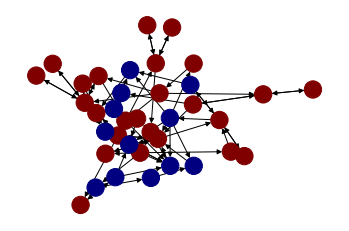


 <---- The nodes with the highest eigenvalues are as follows ----> 

Node: Ryu79726178, Eigenvalue: 0.4941410424754971, opinion: NONE, degree: 22
Node: PaulCra33107260, Eigenvalue: 0.4941410424754971, opinion: NOT_AGAINST, degree: 33
Node: JohnieClayton_, Eigenvalue: 0.3902693869340126, opinion: NONE, degree: 15
Node: sowthewind1, Eigenvalue: 0.3902693869340126, opinion: AGAINST, degree: 28
Node: telesyros, Eigenvalue: 0.29552228361736993, opinion: NOT_AGAINST, degree: 40
Node: ediz1975, Eigenvalue: 0.28639773139252805, opinion: NONE, degree: 16
Node: TflTruth, Eigenvalue: 0.12206153067769622, opinion: NOT_AGAINST, degree: 58
Node: Alfiebubbles, Eigenvalue: 0.09958860955231076, opinion: NOT_AGAINST, degree: 3
Node: ToxicLemon69, Eigenvalue: 0.07865442030955903, opinion: NOT_AGAINST, degree: 33
Node: ossien1, Eigenvalue: 0.05653802602416083, opinion: NOT_AGAINST, degree: 63


'Number of components in LCC[1] = 22'

label  count
2  NOT_AGAINST     15
1         NONE      4
0      AGAINST      3

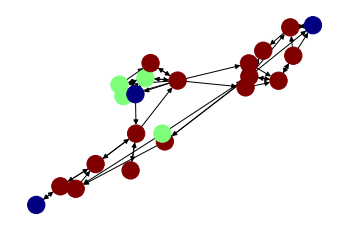


 <---- The nodes with the highest eigenvalues are as follows ----> 

Node: OnLondon, Eigenvalue: 0.48482443959573046, opinion: NOT_AGAINST, degree: 23
Node: BreweryMortlake, Eigenvalue: 0.37897922057150035, opinion: NOT_AGAINST, degree: 20
Node: gmhales, Eigenvalue: 0.319866726868107, opinion: NOT_AGAINST, degree: 22
Node: centreforlondon, Eigenvalue: 0.31986668599345347, opinion: NOT_AGAINST, degree: 9
Node: Listen_toLocals, Eigenvalue: 0.31107057347727374, opinion: NOT_AGAINST, degree: 14
Node: CarolineRussell, Eigenvalue: 0.2977466092966113, opinion: NOT_AGAINST, degree: 23
Node: DaveHill, Eigenvalue: 0.27080660020588715, opinion: NOT_AGAINST, degree: 15
Node: andree_frieze, Eigenvalue: 0.21855465413975744, opinion: NOT_AGAINST, degree: 10
Node: ClareDelmar, Eigenvalue: 0.21855465413975744, opinion: NOT_AGAINST, degree: 10
Node: RichmondNubNews, Eigenvalue: 0.16042456643174294, opinion: NONE, degree: 11


'Number of components in LCC[2] = 12'

label  count
1  NOT_AGAINST     11
0         NONE      1

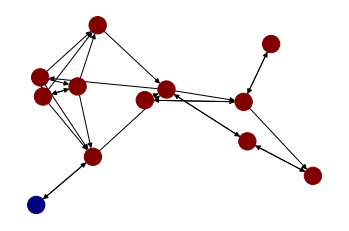


 <---- The nodes with the highest eigenvalues are as follows ----> 

Node: clouise81, Eigenvalue: 0.42944769086406026, opinion: NONE, degree: 20
Node: Fhkierton1, Eigenvalue: 0.42944769086406026, opinion: NONE, degree: 20
Node: mabsval, Eigenvalue: 0.42944769086406026, opinion: NONE, degree: 21
Node: Dryadula, Eigenvalue: 0.4294476908640602, opinion: NONE, degree: 22
Node: DavidMinahan, Eigenvalue: 0.417113063473176, opinion: NONE, degree: 18
Node: JoBellLib, Eigenvalue: 0.19703386021701097, opinion: NONE, degree: 16
Node: Blonde_London, Eigenvalue: 0.15614256303840598, opinion: NONE, degree: 12
Node: sizzabumble, Eigenvalue: 0.1301596353549953, opinion: NONE, degree: 13
Node: dawn_pgl, Eigenvalue: 0.07920885225289995, opinion: NONE, degree: 10
Node: lisa93398349, Eigenvalue: 0.03634118414460633, opinion: NONE, degree: 10


'Number of components in LCC[3] = 11'

label  count
0  NONE     11

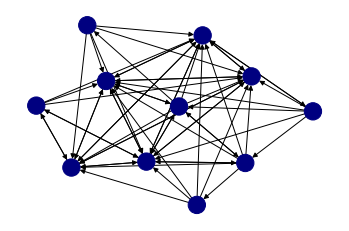


 <---- The nodes with the highest eigenvalues are as follows ----> 

Node: SilvertownTn, Eigenvalue: 0.5374833029364843, opinion: NOT_AGAINST, degree: 150
Node: ZackPolanski, Eigenvalue: 0.46628957513571223, opinion: NOT_AGAINST, degree: 39
Node: DonnachadhMc, Eigenvalue: 0.3193248593690706, opinion: NOT_AGAINST, degree: 14
Node: VictoriaRance, Eigenvalue: 0.2889415480130416, opinion: NOT_AGAINST, degree: 24
Node: CAirCommunities, Eigenvalue: 0.2889415480130416, opinion: NONE, degree: 13
Node: RMBlaber56, Eigenvalue: 0.2889415480130416, opinion: AGAINST, degree: 12
Node: BELLEGREENWICH, Eigenvalue: 0.18792000350458263, opinion: NOT_AGAINST, degree: 11
Node: AMCo1, Eigenvalue: 0.18792000350458263, opinion: NONE, degree: 4
Node: makeitbetterbot, Eigenvalue: 0.18792000350458263, opinion: NOT_AGAINST, degree: 21
Node: hackneywick, Eigenvalue: 0.18792000350458263, opinion: NOT_AGAINST, degree: 23


'Number of components in LCC[4] = 10'

label  count
2  NOT_AGAINST      7
1         NONE      2
0      AGAINST      1

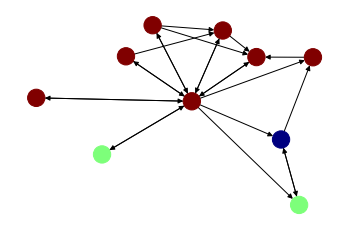

In [28]:
range_limit = 5
for n in range(range_limit):
    draw_strongly_connected(n, components_strong)

### Comments
Components 1 and 4 are more related to traffic/pollution than crime and so we can ignore. We can ignore component 2, because while this group discusses a range of subjects, they aren't related to crime. This leaves components 0 and 3, but component 0 is by far our most interesting component, not least because it is our 'giant' component.
- The majority of the top 10 tweeters can be seen to be anti mayor by virtue of what they tweet on Twitter. So what we can tell is that they interact with each other, because they exist within the same strong component, but we also tell that they are prolific retweeters of other tweeter because their degree value is relatively high compared with the rest of the network
    - We know degree is more heavily influenced by IN degree than out degree, which in turn means they retweet more than they tweet
    
Unfortunately, the majority of this component have been labeled as NOT_AGAINST, when we know they lean AGAINST and so this suggests our opinion classifier is a poor predictor of opinion. We will confirm this by looking at the weak components and the detected communities.

## 4. Derive weakly connected components

### 4.1. Get weak components
Using networkX, derive the weak components, namely the largest subgraphs containing nodes with links in one direction.
- Also assign weak component id as a network attribute
- This code draws heavily on code developed by Bovet [6] and networkX example documentation [7]

In [29]:
components = list(nx.weakly_connected_components(G))

# sort the component according to their size
components = list(sorted(components, key=lambda x:len(x), reverse=True))

In [30]:
components_dict = {} # Create a blank dictionary
for i,c in enumerate(components): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        components_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, components_dict, 'weak_component_id')

#### 4.1.1 View largest weak components by size (number of nodes)

In [31]:
df_components_dict = pd.DataFrame(list(components_dict.items()),columns = ['screen_name','weak_comp_class_id']) 
comp_class_list = df_components_dict.weak_comp_class_id.unique()

print("Number of different weak components = {} ".format(len(comp_class_list)))

df_components_dict_agg = df_components_dict.groupby('weak_comp_class_id').count()

comm_count = 10
print("\nTop {} components, by number of members".format(comm_count))
df_components_dict_agg.head(comm_count)

Number of different weak components = 1535 

Top 10 components, by number of members


screen_name
weak_comp_class_id             
0                         20961
1                           165
2                           163
3                           125
4                            83
5                            43
6                            41
7                            40
8                            36
9                            31

### 4.2 Analyse key attributes for biggest weak components
THere are 1,535 different weak components but the vast majority are immaterial and we can see that component 0, by far the biggest component, contains nearly 80% of all nodes (20,961 out of a total of 26,691 nodes). 

We will now analyse the top 5 components to understand how opinions are expressed across these nodes. 
- We create a dataframe with node attributes to facilitate this analyis

In [32]:
node_attributes = dict(G.nodes())
node_attribute_values = node_attributes.values()

node_attributes_df = pd.DataFrame(node_attribute_values,
                      columns =['name', 
                                'degree',
                                'betweenness',
                                'eigenvector',
                                'opinions',
                                'weak_component_id'])

print("Number of unique tweeters: {:,}".format(node_attributes_df['name'].count()))

node_attributes_df.rename(columns = {'name':'screen_name'}, inplace = True)

Number of unique tweeters: 26,691


In [33]:
component_list = [0,1,2,3,4]

grouped_weak_component = node_attributes_df.groupby(['weak_component_id', 'opinions']).agg({'screen_name': ['count']})
grouped_weak_component.columns = ['count']
grouped_weak_component = grouped_weak_component.reset_index()
grouped_weak_component = grouped_weak_component[grouped_weak_component.weak_component_id.isin(component_list)]
grouped_weak_component

weak_component_id     opinions  count
0                   0      AGAINST   6756
1                   0          FOR      4
2                   0         NONE   2595
3                   0  NOT_AGAINST  11606
4                   1      AGAINST    140
5                   1  NOT_AGAINST     25
6                   2      AGAINST     17
7                   2         NONE     11
8                   2  NOT_AGAINST    135
9                   3         NONE      3
10                  3  NOT_AGAINST    122
11                  4      AGAINST     20
12                  4         NONE     14
13                  4  NOT_AGAINST     49

#### 4.2.1 Create a treemap to analyse proportion of tweeters AGAINST and NOT AGAINST within our largest weak components

In [34]:
import plotly.express as px
fig = px.treemap(grouped_weak_component, path=['weak_component_id', 'opinions'], values='count', color='opinions',
                 color_discrete_map={'AGAINST':'rgb(104,132,236)', 'NOT_AGAINST':'rgb(209,101,92)', 
                                      'FOR':'yellow', 
                                      'None':'lightgrey'},
                title="Top 6 weak components: proportions AGAINST, NOT_AGAINST, FOR, NONE")
# this is what I don't like, accessing traces like this
fig.data[0].textinfo = 'label+text+value+percent parent+percent root'

fig.layout.hovermode = False
fig.show()

fig = px.treemap(grouped_weak_component, path=['opinions', 'weak_component_id'], values='count', color='opinions',
                 color_discrete_map={'AGAINST':'rgb(104,132,236)', 'NOT_AGAINST':'rgb(209,101,92)', 
                                      'FOR':'yellow', 
                                      'None':'lightgrey'},
                title="Labels AGAINST, NOT_AGAINST, FOR, NONE across weak components")
# this is what I don't like, accessing traces like this
fig.data[0].textinfo = 'label+text+value+percent parent+percent root'

fig.layout.hovermode = False
fig.show()

#### Comments
Component 0 contains by far the majority of nodes and so we will focus on it.
- NOT_AGAINST nodes comprise around 55% of all nodes in component 0, while AGAINST comprises 32%. If we also consider the 12% with no label we can say that the biggest component largely expresses no opinion on the causes of crime. THis is broadly in keeping with the percentage of AGAINST nodes across the entire tweet corpus, which we calculated in notebook 1_10 (AGAINST => 8,226/23,108 => 36%)
- We can also see that 97% of all nodes designated with opinion of AGAINST reside in component 0 (strictly speaking this is 97% of all nodes across the top 5 weak components, which in turn represent 80% of all nodes)

This means that component 0 is by far our most important node.

### 4.3. Visualise and discuss the weak components
We will draw the subgraphs for each of the top 5 weak components and color the nodes according to their designated opinion. We will also display the tweeters in the components with the highest eignenvector centrality

In [35]:
def display_weak_components(n, components, G):
    # let's make a new graph which is the subgraph of G corresponding to index=n
    
    print("\n<------------- subcomponent: {} --------------->\n".format(n))
    
    
    # First get a list of just the nodes in that class
    comp_id = [i for i in G.nodes() if G.nodes[i]['weak_component_id'] == n]

    # Then create a dictionary of the eigenvector centralities of those nodes
    comp_eigenvector = {n:G.nodes[n]['eigenvector'] for n in comp_id}

    # Then sort that dictionary and print the first n results
    print_count=10
    comp_sorted_by_eigenvector = sorted(comp_eigenvector.items(), key=itemgetter(1), reverse=True)

    print("\n<--- Modularity Class {} Sorted by Eigenvector Centrality, top {} values --->".format(n, print_count))
    for node in comp_sorted_by_eigenvector[:print_count]:
        
        degree =  G.nodes[node[0]]['degree']
        opinion =  G.nodes[node[0]]['opinions']
        
        print("Name: {}, Eigenvector Centrality: {}, degree: {}, opinion: {}".format(node[0], 
                                                                                     node[1],
                                                                                     degree,
                                                                                     opinion))

    largest_comp = components[n]
    LCC = G.subgraph(largest_comp)  
    
    display("Number of nodes in current subcomponent: {:,}".format(LCC.number_of_nodes()))
        
    # now set colors
    opinions = set(nx.get_node_attributes(LCC,'opinions').values())
    mapping = dict(zip(sorted(opinions),count()))
    
    nodes = LCC.nodes()
    colors = [mapping[LCC.nodes[n]['opinions']] for n in nodes]
    
    colors_df = pd.DataFrame(colors, columns=['color'])
    colors_agg_df = colors_df.groupby(["color"]).apply(lambda x: x['color'].count()).reset_index()
    colors_agg_df.rename(columns = {0:'count'}, inplace = True)
    
    # need to swap keys and values - https://www.geeksforgeeks.org/python-program-to-swap-keys-and-values-in-dictionary/
    new_mapping = dict([(value, key) for key, value in mapping.items()])
       
    colors_agg_df['label'] = ''
    colors_agg_df['label'] = colors_agg_df.apply(lambda x: color_lookup(x['color'], new_mapping), axis=1)
    
    display(colors_agg_df[['label', 'count']].sort_values(by='count', ascending=False))
        
    if n > 0:
        
        pos = nx.spring_layout(LCC)
    
        plt.figure(figsize=(15,15))
        plt.axis('off')
        nx.draw_networkx(LCC, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=300, cmap=plt.cm.jet)
        plt.show()


<------------- subcomponent: 0 --------------->


<--- Modularity Class 0 Sorted by Eigenvector Centrality, top 10 values --->
Name: SadiqKhan, Eigenvector Centrality: 0.0017548950166119419, degree: 1296, opinion: NOT_AGAINST
Name: MayorofLondon, Eigenvector Centrality: 0.001056095504433749, degree: 933, opinion: NOT_AGAINST
Name: dotmit, Eigenvector Centrality: 0.0007432423802312818, degree: 8, opinion: NONE
Name: delgueg, Eigenvector Centrality: 0.0007432423802312818, degree: 8, opinion: NONE
Name: PaulCra33107260, Eigenvector Centrality: 0.0005870128391632943, degree: 33, opinion: NOT_AGAINST
Name: LornaBlane, Eigenvector Centrality: 0.0005870128391632943, degree: 9, opinion: NOT_AGAINST
Name: Ryu79726178, Eigenvector Centrality: 0.0005870128391632942, degree: 22, opinion: NONE
Name: arben_sallaku, Eigenvector Centrality: 0.0005541738471667079, degree: 7, opinion: NONE
Name: LeaveEUOfficial, Eigenvector Centrality: 0.0005281770655161472, degree: 737, opinion: NOT_AGAINST
Name: Shau

'Number of nodes in current subcomponent: 20,961'

label  count
3  NOT_AGAINST  11606
0      AGAINST   6756
2         NONE   2595
1          FOR      4


<------------- subcomponent: 1 --------------->


<--- Modularity Class 1 Sorted by Eigenvector Centrality, top 10 values --->
Name: m_ontatta20, Eigenvector Centrality: 1.4155308814487682e-16, degree: 144, opinion: AGAINST
Name: Taehyung_india_, Eigenvector Centrality: 2.362778682285498e-17, degree: 24, opinion: NOT_AGAINST
Name: alsaad_fofo, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: TashmiAmadi, Eigenvector Centrality: 4.2726558450009027e-20, degree: 2, opinion: NOT_AGAINST
Name: MuskanP25267761, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: Lily_stans_BTS, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: BTSV_retwt, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: ToTmmyy, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: formyVmisun1230, Eigenvector Centrality: 4.2726558450009027e-20, degre

'Number of nodes in current subcomponent: 165'

label  count
0      AGAINST    140
1  NOT_AGAINST     25

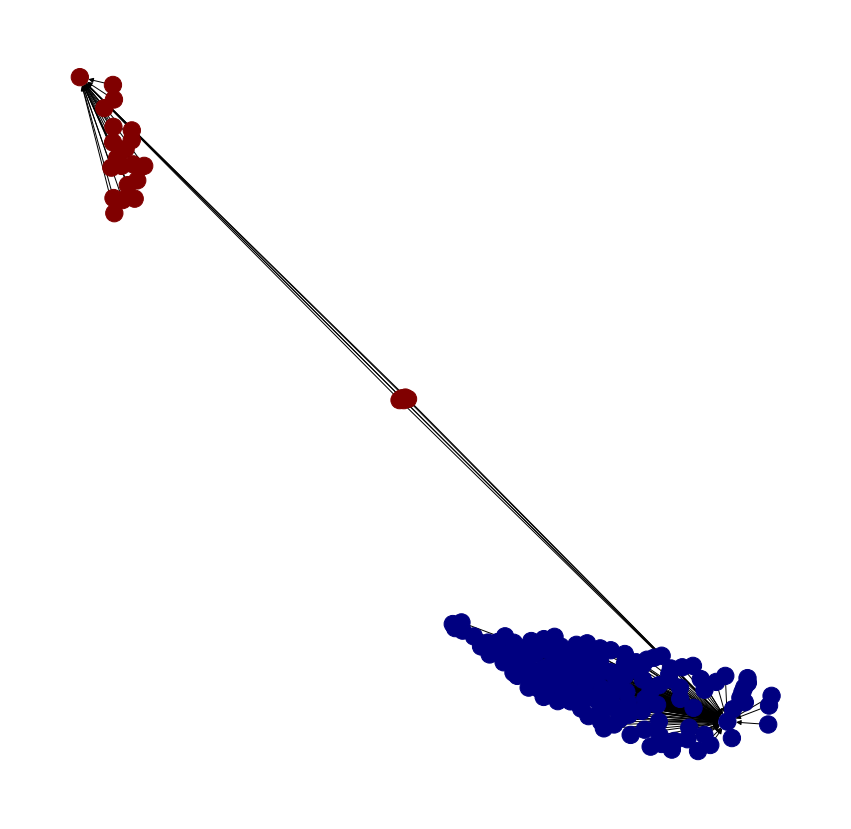


<------------- subcomponent: 2 --------------->


<--- Modularity Class 2 Sorted by Eigenvector Centrality, top 10 values --->
Name: KeshooBai, Eigenvector Centrality: 1.9363676289543893e-16, degree: 131, opinion: NOT_AGAINST
Name: DRMAHREENBHUTTO, Eigenvector Centrality: 2.362778682285498e-17, degree: 24, opinion: AGAINST
Name: Khalid_Munir, Eigenvector Centrality: 1.1835256690652532e-17, degree: 12, opinion: NONE
Name: drafaquepsf, Eigenvector Centrality: 5.9389916245512485e-18, degree: 7, opinion: NOT_AGAINST
Name: syedOwais01, Eigenvector Centrality: 4.2726558450009027e-20, degree: 2, opinion: NOT_AGAINST
Name: EngrQadeerAhme1, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: SYedShilShhBuk1, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: AGAINST
Name: WahidPitafi, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NONE
Name: Ashokemaghwar, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion:

'Number of nodes in current subcomponent: 163'

label  count
2  NOT_AGAINST    135
0      AGAINST     17
1         NONE     11

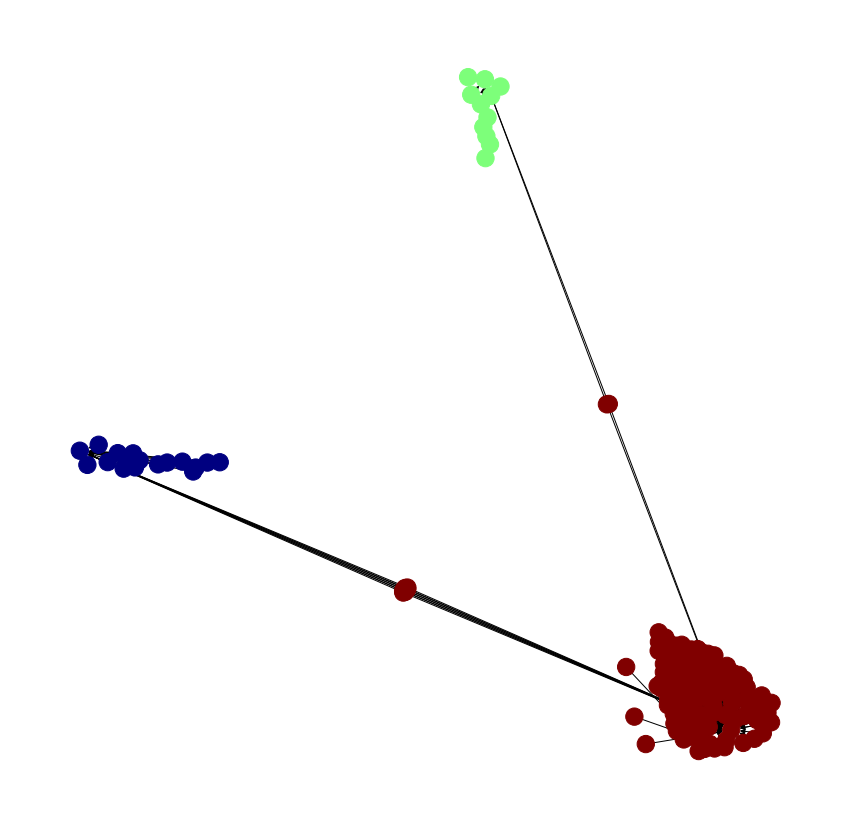


<------------- subcomponent: 3 --------------->


<--- Modularity Class 3 Sorted by Eigenvector Centrality, top 10 values --->
Name: aceattorneygame, Eigenvector Centrality: 1.2189887125787564e-16, degree: 124, opinion: NONE
Name: BY0SUke, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: swagtastic326, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: basefjodryan, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: RubyFighter16, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: Watchthesky6, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NONE
Name: FADDON24, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: Lv100Tweets, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT_AGAINST
Name: VicHellion, Eigenvector Centrality: 4.2726558450009027e-20, degree: 1, opinion: NOT

'Number of nodes in current subcomponent: 125'

label  count
1  NOT_AGAINST    122
0         NONE      3

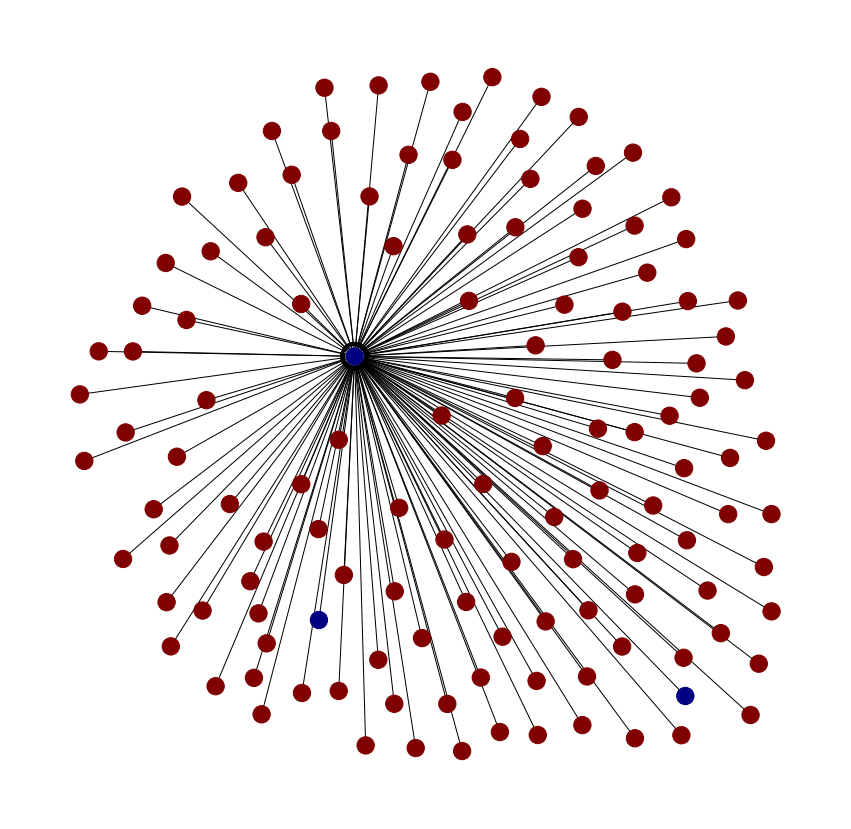

In [36]:
my_range = range(0, 4) # n.b. 0 is too large so takes too long to display

for n in my_range:
    display_weak_components(n, components, G)

### Comments
The only component of interest apart from the giant component is component 1 and that is because 140 of 165 nodes have been given a label = 'AGAINST'. However, even in this component, the most important nodes all have label = 'NOT AGAINST' apart from one node, but reviewing Twitter reveals that node to tweet content that is unrelated to crime. Reviewing other nodes within this component reveals the component is actually a discussion on K Pop and so we will not analyse this node any further.

This leaves component 0, which we will now investigate in more detail.

In [37]:
comp_zero_nodes = [i for i in G.nodes() if G.nodes[i]['weak_component_id'] == 0]

comp_zero_eigenvector = {n:G.nodes[n]['eigenvector'] for n in comp_zero_nodes}

comp_sorted_by_eigenvector = sorted(comp_zero_eigenvector.items(), key=itemgetter(1), reverse=True)

print("\n<--- Modularity Class 0 Sorted by Eigenvector Centrality, top 25 values --->")
for node in comp_sorted_by_eigenvector[:25]:
        
    in_degree =  G.nodes[node[0]]['in_degree']
    out_degree =  G.nodes[node[0]]['out_degree']
    opinion =  G.nodes[node[0]]['opinions']
        
    print("Name: {}, Eigenvector Centrality: {}, in_degree: {}, out_degree: {}, opinion: {}".format(node[0], 
                                                                                 node[1],
                                                                                 in_degree,
                                                                                 out_degree,
                                                                                 opinion))


<--- Modularity Class 0 Sorted by Eigenvector Centrality, top 25 values --->
Name: SadiqKhan, Eigenvector Centrality: 0.0017548950166119419, in_degree: 1296, out_degree: 0, opinion: NOT_AGAINST
Name: MayorofLondon, Eigenvector Centrality: 0.001056095504433749, in_degree: 933, out_degree: 0, opinion: NOT_AGAINST
Name: dotmit, Eigenvector Centrality: 0.0007432423802312818, in_degree: 8, out_degree: 0, opinion: NONE
Name: delgueg, Eigenvector Centrality: 0.0007432423802312818, in_degree: 8, out_degree: 0, opinion: NONE
Name: PaulCra33107260, Eigenvector Centrality: 0.0005870128391632943, in_degree: 7, out_degree: 26, opinion: NOT_AGAINST
Name: LornaBlane, Eigenvector Centrality: 0.0005870128391632943, in_degree: 7, out_degree: 2, opinion: NOT_AGAINST
Name: Ryu79726178, Eigenvector Centrality: 0.0005870128391632942, in_degree: 5, out_degree: 17, opinion: NONE
Name: arben_sallaku, Eigenvector Centrality: 0.0005541738471667079, in_degree: 7, out_degree: 0, opinion: NONE
Name: LeaveEUOfficia

### Comments
Reviewing the top 25 tweeters by eigenvector is not particularly useful because it returns a mix of tweeters that are talking about both traffic and crime. However, from this snapshot we can see that nodes with the higher in_degree value relate to nodes that have been critical about the mayor on crime and this merits further investigation.

In [38]:
comp_zero_nodes = [i for i in G.nodes() if G.nodes[i]['weak_component_id'] == 0]

comp_zero_in_degree = {n:G.nodes[n]['in_degree'] for n in comp_zero_nodes}

comp_zero_in_degree = sorted(comp_zero_in_degree.items(), key=itemgetter(1), reverse=True)

print("\n<--- Modularity Class 0 Sorted by in degree, top 25 values --->")
for node in comp_zero_in_degree[:25]:
        
    opinion =  G.nodes[node[0]]['opinions']        
    print("Name: {}, in_degree: {}, opinion: {}".format(node[0], 
                                                                        node[1],
                                                                        opinion))


<--- Modularity Class 0 Sorted by in degree, top 25 values --->
Name: SadiqKhan, in_degree: 1296, opinion: NOT_AGAINST
Name: MayorofLondon, in_degree: 933, opinion: NOT_AGAINST
Name: KoolKat1025, in_degree: 912, opinion: AGAINST
Name: GBNEWS, in_degree: 875, opinion: NOT_AGAINST
Name: James_Thorburn, in_degree: 853, opinion: NOT_AGAINST
Name: NKrankie, in_degree: 739, opinion: AGAINST
Name: LeaveEUOfficial, in_degree: 737, opinion: NOT_AGAINST
Name: LeoKearse, in_degree: 635, opinion: AGAINST
Name: LeslieH24367191, in_degree: 563, opinion: NOT_AGAINST
Name: MartinDaubney, in_degree: 528, opinion: NOT_AGAINST
Name: standardnews, in_degree: 520, opinion: NOT_AGAINST
Name: polblonde, in_degree: 489, opinion: NOT_AGAINST
Name: 2tweetaboutit, in_degree: 488, opinion: AGAINST
Name: metpoliceuk, in_degree: 469, opinion: AGAINST
Name: LozzaFox, in_degree: 444, opinion: NOT_AGAINST
Name: BrexitBassist, in_degree: 433, opinion: NOT_AGAINST
Name: NormanBrennan, in_degree: 383, opinion: AGAINST
N

### Comments
We would expect to see the nodes with the highest in_degree values because this component contains most of the nodes and so in reality not sure this tells us very much about the community beyond it containing most of the nodes. However, reviewing the opinions assigned to the tweeters in this list appears to <b>confirm what we saw previously with the strong networks, which is that the opinion classifier is not a strong predictor of opinions</b>. This is because the majority of tweeters are classified as being NOT_AGAINST the Mayor yet reviewing their tweets on Twitter suggests they aren't fans. 

## 5. Community detection

### 5.1. Identify communities
Using networkX, use community detection to identify communities within our network. Also assign community as a node attribute
- networkX use greedy modularity to detect communities and so we first need to convert our directed graph to an undirected graph
- This code draws heavily on code presented in a tutorial by Ladd [5]

In [39]:
H = nx.Graph(G) 

communities = community.greedy_modularity_communities(H)

In [40]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

In [41]:
df_community_dict = pd.DataFrame(list(modularity_dict.items()),columns = ['screen_name','class_id']) 
class_list = df_community_dict.class_id.unique()

print("Number of different communities = {} ".format(len(class_list)))

df_community_dict_agg = df_community_dict.groupby('class_id').count()

comm_count = 10
print("\nTop {} communities, by number of members".format(comm_count))
df_community_dict_agg.head(comm_count)

Number of different communities = 1669 

Top 10 communities, by number of members


screen_name
class_id             
0                5247
1                3808
2                1680
3                1011
4                1010
5                 772
6                 681
7                 582
8                 506
9                 504

### 5.2 Analyse key attributes for biggest communities
THere are 1,669  different communities and  but the vast majority are immaterial and we can see that the top 10 communities contain nearly 60% of all nodes (15,801 out of a total of 26,691 nodes).

We will now analyse the top 10 communities to understand how opinions are expressed across these nodes.

In [42]:
node_attributes = dict(G.nodes())
node_attribute_values = node_attributes.values()

node_attributes_df = pd.DataFrame(node_attribute_values,
                      columns =['name', 
                                'degree',
                                'betweenness',
                                'eigenvector',
                                'opinions',
                                'modularity'])

node_attributes_df.rename(columns = {'modularity':'community_id'}, inplace = True)
node_attributes_df.rename(columns = {'name':'screen_name'}, inplace = True)

In [43]:
community_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

grouped_community = node_attributes_df.groupby(['community_id', 'opinions']).agg({'screen_name': ['count']})
grouped_community.columns = ['count']
grouped_community = grouped_community.reset_index()
grouped_community = grouped_community[grouped_community.community_id.isin(community_list)]

In [44]:
fig = px.treemap(grouped_community, path=['community_id', 'opinions'], values='count', color='opinions',
                 color_discrete_map={'AGAINST':'rgb(104,132,236)', 'NOT_AGAINST':'rgb(209,101,92)', 
                                      'FOR':'yellow', 
                                      'None':'lightgrey'},
                title="Top communities: proportions AGAINST, NOT_AGAINST, FOR, NONE")

# this is what I don't like, accessing traces like this
fig.data[0].textinfo = 'label+text+value+percent parent+percent root'

fig.layout.hovermode = False
fig.show()

fig = px.treemap(grouped_community, path=['opinions', 'community_id'], values='count', color='opinions',
                 color_discrete_map={'AGAINST':'rgb(104,132,236)', 'NOT_AGAINST':'rgb(209,101,92)', 
                                      'FOR':'yellow', 
                                      'None':'lightgrey'},
                title="AGAINST, NOT_AGAINST, FOR, NONE across communities")

# this is what I don't like, accessing traces like this
fig.data[0].textinfo = 'label+text+value+percent parent+percent root'

fig.layout.hovermode = False
fig.show()

#### Comments
The communities in which AGAINST forms the biggest proportion are 0, 5 and 9 and these 3 communities contain 65% of all AGAINST nodes. Of these communities, community 0 presents the most interesting case:
- it's the biggest node by size, containing approximately one third of all nodes in the top 10 communities 
- 54% of nodes in community 0 have opinion = AGAINST, which outperforms the 35% of nodes that are AGAINST across the entire tweeter community
- 50% of all nodes with opinion = AGAINST are in community 0

We will therefor analyse communities 0, 5 and 9 further and pay particular attention to community 0

### 5.3. Visualise and discuss the top communities
We will draw the subgraphs for the top 3 communites and color the nodes according to their designated opinion. We will also display the tweeters in the components with the highest eignenvector centrality


In [45]:
from matplotlib import pyplot as plt
    
def print_class_members(class_num, print_count):

    # First get a list of just the nodes in that class
    class_id = [n for n in G.nodes() if G.nodes[n]['modularity'] == class_num]

    # Then create a dictionary of the eigenvector centralities of those nodes
    class_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class_id}

    # Then sort that dictionary and print the first 5 results
    class_sorted_by_eigenvector = sorted(class_eigenvector.items(), key=itemgetter(1), reverse=True)

    print("\n<--- Modularity Class {} Sorted by Eigenvector Centrality, top {} values --->".format(class_num, count))
    for node in class_sorted_by_eigenvector[:print_count]:
        
        degree =  G.nodes[node[0]]['degree']
        opinion =  G.nodes[node[0]]['opinions']
        
        print("Name: {}, Eigenvector Centrality: {}, degree: {}, opinion: {}".format(node[0], 
                                                                                     node[1],
                                                                                     degree,
                                                                                     opinion))
        
    
    my_subgraph = G.subgraph(class_id)
    
    # now set colors
    nodes = my_subgraph.nodes()
    opinions = set(nx.get_node_attributes(my_subgraph,'opinions').values())
    mapping = dict(zip(sorted(opinions),count()))
    
    colors = [mapping[my_subgraph.nodes[n]['opinions']] for n in nodes]
    
    colors_df = pd.DataFrame(colors, columns=['color'])
    colors_agg_df = colors_df.groupby(["color"]).apply(lambda x: x['color'].count()).reset_index()
    colors_agg_df.rename(columns = {0:'count'}, inplace = True)
    
    # need to swap keys and values - https://www.geeksforgeeks.org/python-program-to-swap-keys-and-values-in-dictionary/
    new_mapping = dict([(value, key) for key, value in mapping.items()])
       
    colors_agg_df['label'] = ''
    colors_agg_df['label'] = colors_agg_df.apply(lambda x: color_lookup(x['color'], new_mapping), axis=1)
    
    display(colors_agg_df[['label', 'count']].sort_values(by='count', ascending=False))
    
    pos = nx.spring_layout(my_subgraph)
    
    plt.figure(figsize=(20,20))
    plt.axis('off')
    nx.draw_networkx(my_subgraph, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=300, cmap=plt.cm.jet)
    plt.show()


<----- class 0 ----->

<--- Modularity Class 0 Sorted by Eigenvector Centrality, top <class 'itertools.count'> values --->
Name: LeaveEUOfficial, Eigenvector Centrality: 0.0005281770655161472, degree: 737, opinion: NOT_AGAINST
Name: MickeyD44314901, Eigenvector Centrality: 0.00044194818900669604, degree: 391, opinion: AGAINST
Name: James_Thorburn, Eigenvector Centrality: 0.00041746151024638425, degree: 872, opinion: NOT_AGAINST
Name: NKrankie, Eigenvector Centrality: 0.00041645249804331383, degree: 742, opinion: AGAINST
Name: LeslieH24367191, Eigenvector Centrality: 0.00036722156728325795, degree: 575, opinion: NOT_AGAINST
Name: HarrietSergeant, Eigenvector Centrality: 0.00025986708563977137, degree: 286, opinion: NOT_AGAINST
Name: telegraph, Eigenvector Centrality: 0.00023600091729384363, degree: 96, opinion: NONE
Name: KhanMustGo, Eigenvector Centrality: 0.0002243499650219876, degree: 259, opinion: NOT_AGAINST
Name: NormanBrennan, Eigenvector Centrality: 0.00022067200059401067, degre

label  count
0      AGAINST   2825
3  NOT_AGAINST   2206
2         NONE    214
1          FOR      2

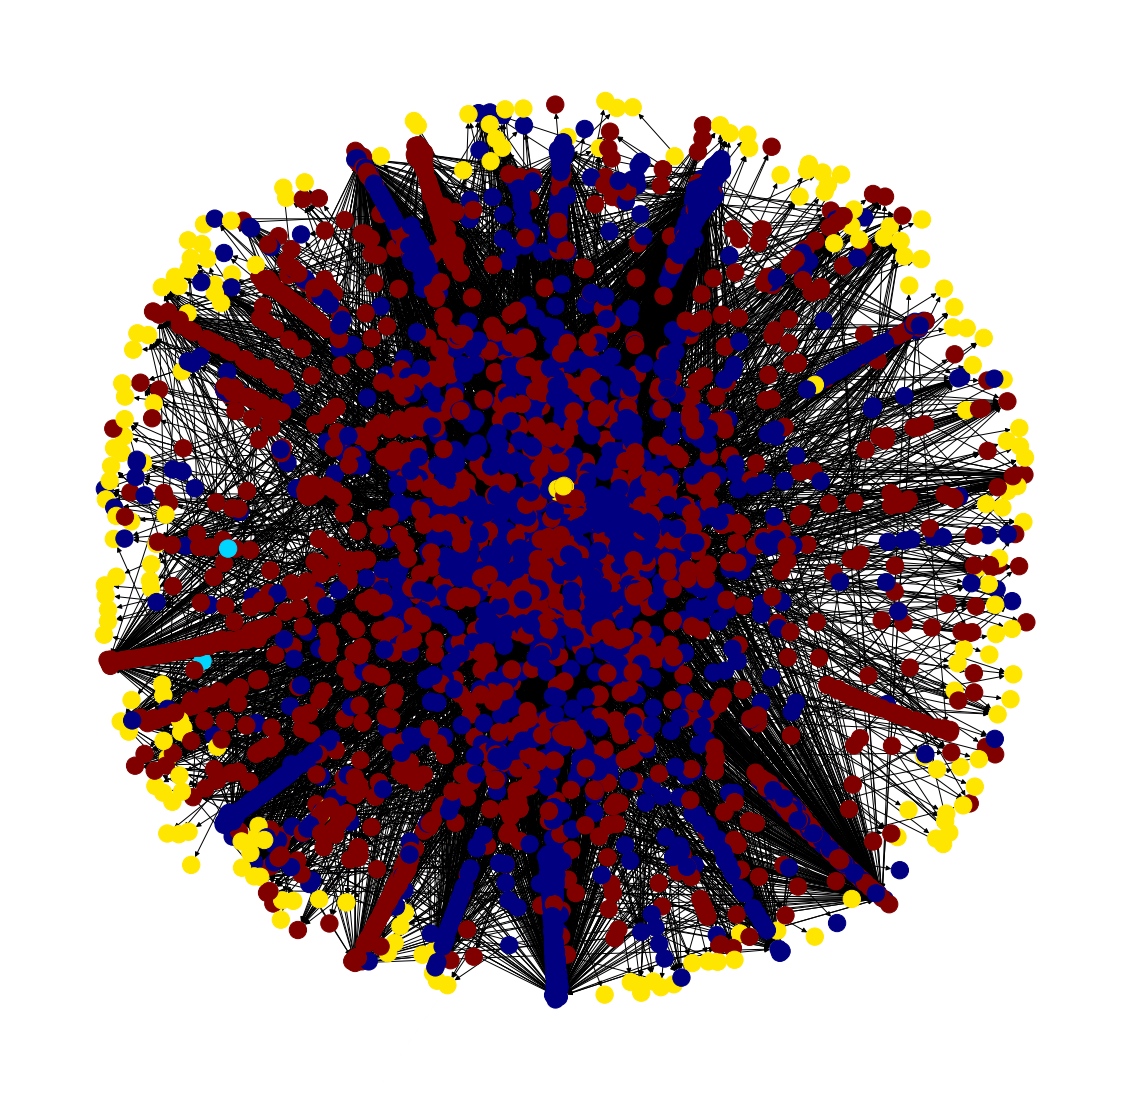

<----- class 5 ----->

<--- Modularity Class 5 Sorted by Eigenvector Centrality, top <class 'itertools.count'> values --->
Name: GBNEWS, Eigenvector Centrality: 0.00040672553118658927, degree: 875, opinion: NOT_AGAINST
Name: linmeitalks, Eigenvector Centrality: 5.200072083764485e-06, degree: 13, opinion: AGAINST
Name: LisaMil36579884, Eigenvector Centrality: 2.656826725153796e-06, degree: 32, opinion: AGAINST
Name: VRnews101, Eigenvector Centrality: 2.4132856848323746e-06, degree: 6, opinion: AGAINST
Name: Timmy200012, Eigenvector Centrality: 2.4132856848323746e-06, degree: 7, opinion: NOT_AGAINST
Name: ZSocials, Eigenvector Centrality: 1.7849137161828209e-06, degree: 6, opinion: AGAINST
Name: Miss_Snuffy, Eigenvector Centrality: 1.2646040006565272e-06, degree: 3, opinion: NONE
Name: Alexwhatdaa, Eigenvector Centrality: 1.2646040006240977e-06, degree: 3, opinion: NONE
Name: OhHeWentThere, Eigenvector Centrality: 9.353259172458176e-07, degree: 1, opinion: NONE
Name: _AngloMatt, Eigenvec

label  count
0      AGAINST    399
2  NOT_AGAINST    276
1         NONE     97

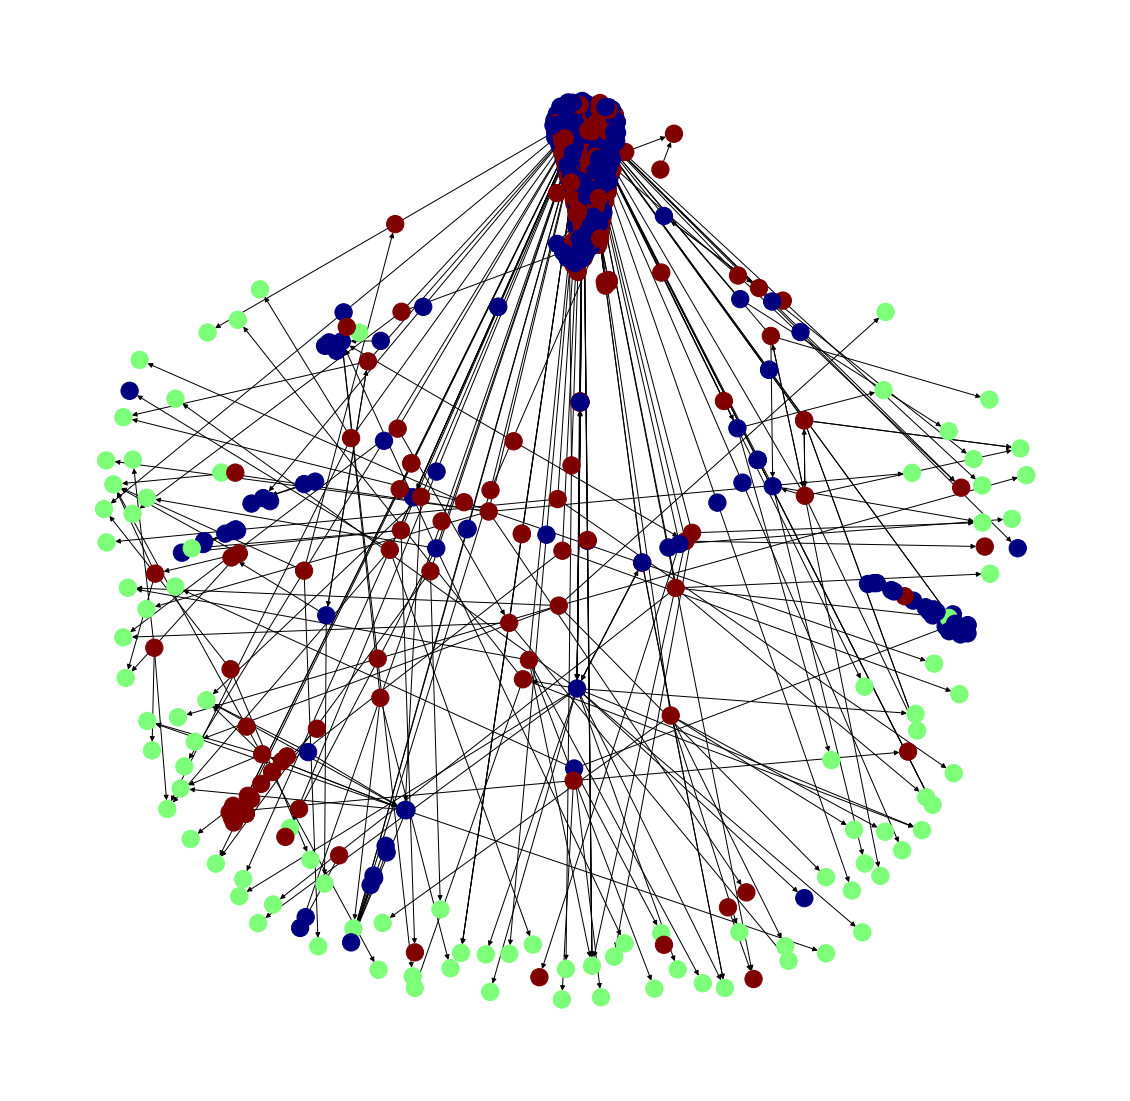

<----- class 9 ----->

<--- Modularity Class 9 Sorted by Eigenvector Centrality, top <class 'itertools.count'> values --->
Name: LeoKearse, Eigenvector Centrality: 1.1500646555649894e-06, degree: 635, opinion: AGAINST
Name: SaveVTG, Eigenvector Centrality: 3.5841631157231053e-12, degree: 11, opinion: NOT_AGAINST
Name: maxwell_marlow, Eigenvector Centrality: 3.5841631157231053e-12, degree: 11, opinion: NOT_AGAINST
Name: KatySei, Eigenvector Centrality: 3.584163500262133e-13, degree: 4, opinion: AGAINST
Name: leedsforbritain, Eigenvector Centrality: 3.584163500262133e-13, degree: 2, opinion: NOT_AGAINST
Name: cityam, Eigenvector Centrality: 2.3627786822854996e-17, degree: 2, opinion: NONE
Name: CalamityClaire4, Eigenvector Centrality: 1.3800678379352913e-17, degree: 4, opinion: AGAINST
Name: MartinCainActon, Eigenvector Centrality: 1.2817967535002706e-17, degree: 3, opinion: AGAINST
Name: janice63267886, Eigenvector Centrality: 1.1835256690652498e-17, degree: 1, opinion: NONE
Name: paulJ

label  count
0      AGAINST    448
2  NOT_AGAINST     49
1         NONE      7

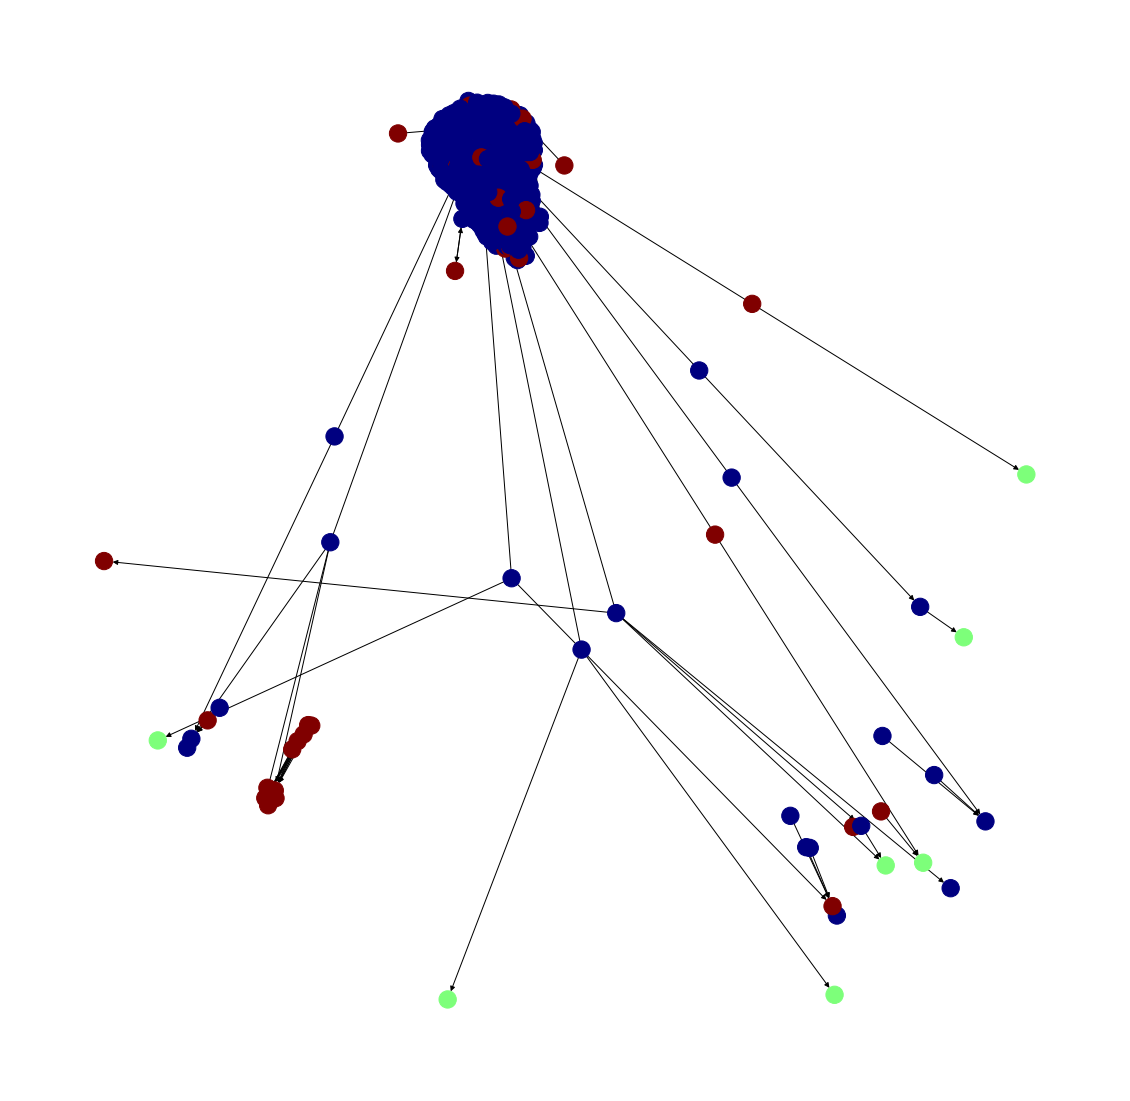

In [46]:
top_member_count = 20

community_list = [0, 5, 9]

for community_id in community_list:
    print("<----- class {} ----->".format(community_id))
    print_class_members(community_id, top_member_count)


### Comments
- Community 0
    - Our biggest component by some way and the one containing most AGAINST opinions
    - Reviewing the most important tweeters having AGAINST label confirmed that label was reasonable for all but 2 cases
    - Reviewing the label of a sample of NOT_AGAINST labels suggests a number should have been labeled AGAINST.
    - The eignenvectors for a number of these tweeters are high as is their degree which means they are both influential and also prolific retweeters (degree is heavily influenced by 'in' degree).

- Community 5
    - Definitely speaking about crime and the proportion labeled as NONE means lots of members have been retweeted rather than originated tweets themselves.
    - Most of the AGAINST and NOT AGAINST seem reasonably labeled although there were erroneous labels in both classes. Though not many
    - This does appear to be a community that is largely AGAINST and although its most important member GBNEWS was labeled NOT_AGAINST, it does host a number of commentators known to be against the Mayor on a range of subjects (masks, traffic and crime).
    
- Community 9
    - Talking about crime but many of the most important nodes have been incorrectly labeled as AGAINST when reviewing their Twitter output suggests otherwise. Interesting that so many in this group but tweets they sent often contained single words like 'stabbed' or 'stabbig' and that led to them being automatically labeled as AGAINST.
    - I would conclude that this group is talking about violent crime but many are being mislabeled based on few tweets containing one or two trigger words.

### 5.4 Compare membership of strong components and communities
we will now see which communities the members of the giant strong component reside in. We are looking to see if there is a relationship. We don't do this for the giant weak component because we know there will be a large overlap by virtue of this component containing almost 80% of all nodes and so it won't really tell us anything.

In [47]:
df_strong_components = pd.DataFrame(components_strong[0], columns=['screen_name'])
df_strong_components['component_name'] = 'WCGC'

df_community_strong_compare = pd.merge(df_strong_components, node_attributes_df, how='inner', 
                                       left_on='screen_name', right_on='screen_name')

df_community_strong_compare.sort_values(by=['community_id', 'opinions'])

screen_name component_name  degree   betweenness   eigenvector  \
2    LSW12612672511           WCGC      53  2.007750e-05  2.105543e-05   
7        ByrneBarry           WCGC      68  1.019510e-05  4.200878e-05   
11       Mal_DuBois           WCGC     151  3.144076e-05  4.835465e-07   
14  LSadler16861851           WCGC      19  1.402981e-04  6.168453e-05   
15    2tweetaboutit           WCGC     492  1.200257e-04  2.156430e-04   
18  JonathanNichol4           WCGC       2  0.000000e+00  4.731787e-05   
20          BluR4y_           WCGC       8  3.717441e-05  4.604770e-05   
25         SJ141123           WCGC       7  2.330195e-06  6.168453e-05   
31  VictoryDay_Hope           WCGC       4  5.185686e-06  1.152949e-06   
34  MickeyD44314901           WCGC     391  2.435794e-04  4.419482e-04   
36    TRFlAGSHAGGER           WCGC       7  1.458838e-05  4.631741e-06   
0       NeilEastell           WCGC      29  1.961103e-05  1.402097e-04   
1      suemitch2017           WCGC     122  2.175699e-04  2.062649e-04   
3   bigfrankbutch12           WCGC       8  3.713717e-06  9.547981e-06   
4        KingBobIIV           WCGC     121  1.336939e-04  3.910193e-05   
5         LeeRaldar           WCGC      30  2.838914e-05  1.615557e-04   
8        OldSparky6           WCGC       5  2.717541e-06  1.159243e-06   
13    kakiOwakagirl           WCGC       6  1.173545e-04  1.198768e-05   
16           JSDH_S           WCGC       6  3.903859e-06  7.216499e-06   
19     AdvertMan999           WCGC       7  4.144852e-06  6.583950e-05   
21   firstforensic3           WCGC       2  0.000000e+00  1.497600e-06   
22        Simon_S70           WCGC      98  2.097869e-04  1.824512e-04   
24       The_Fogeys           WCGC      34  2.827509e-05  4.701875e-06   
26     Stan_VoWales           WCGC      30  7.441674e-05  1.066927e-05   
27            duncr           WCGC      26  3.075297e-05  3.488015e-06   
28  LeslieH24367191           WCGC     575  3.754005e-04  3.672216e-04   
29   James_Thorburn           WCGC     872  4.947530e-04  4.174615e-04   
30        simon4124           WCGC     177  8.975536e-05  1.374904e-04   
32       Praeceps69           WCGC       6  4.111791e-06  3.481722e-06   
33         eairtap1           WCGC       7  2.051393e-05  1.497600e-06   
35  GlobalBritain21           WCGC     133  3.669984e-05  1.413626e-04   
12  ArthurDaley1262           WCGC      17  4.818759e-05  6.583950e-05   
9      flossyflange           WCGC      32  7.428880e-06  3.853366e-07   
17  KirkMoritz_1to1           WCGC       5  0.000000e+00  3.481722e-06   
23       BigDBarber           WCGC       6  0.000000e+00  3.481722e-06   
10     DavidPoulden           WCGC      28  1.632503e-05  6.583950e-05   
6        JodamiSeti           WCGC       3  2.934036e-07  6.168453e-05   

       opinions  community_id  
2       AGAINST             0  
7       AGAINST             0  
11      AGAINST             0  
14      AGAINST             0  
15      AGAINST             0  
18      AGAINST             0  
20      AGAINST             0  
25      AGAINST             0  
31      AGAINST             0  
34      AGAINST             0  
36      AGAINST             0  
0   NOT_AGAINST             0  
1   NOT_AGAINST             0  
3   NOT_AGAINST             0  
4   NOT_AGAINST             0  
5   NOT_AGAINST             0  
8   NOT_AGAINST             0  
13  NOT_AGAINST             0  
16  NOT_AGAINST             0  
19  NOT_AGAINST             0  
21  NOT_AGAINST             0  
22  NOT_AGAINST             0  
24  NOT_AGAINST             0  
26  NOT_AGAINST             0  
27  NOT_AGAINST             0  
28  NOT_AGAINST             0  
29  NOT_AGAINST             0  
30  NOT_AGAINST             0  
32  NOT_AGAINST             0  
33  NOT_AGAINST             0  
35  NOT_AGAINST             0  
12  NOT_AGAINST             1  
9       AGAINST             5  
17  NOT_AGAINST             7  
23  NOT_AGAINST             7  
10  NOT_AGAINST            45  
6   NOT_AGA

### Comments
31 out of 37 of the WCGC component nodes are within community = 0.
Even though this community has a higher proportion of opinions = AGAINST, the majority of key twitter users have been labeled as being not against. Manually reviewing* these users on Twitter suggests the following:
- only 1 of the users labeled AGAINST should be labeled NOT AGAINST
- 9 of the first 10 users labeled NOT_AGAINST should be labeled against.


* The manual review entailed looking up the user screen name in our tweet corpus to see their body of tweets to see if we could assess their opinion. If we could not we looked them up on Twitter, reviewing their bio and between 5-10 tweets. If adverse opinion wasn't observed in the first 10 tweets then an opinion of NOT_AGAINST was assumed.

## 6. Conclusions
The intention of this research and this notebook in particular was to answer the following two research questions:
- RQ1: Can Twitter sentiment analysis determine the proportions of Twitter users that accept or reject the London Mayor’s evidence that ‘deprivation in the leading cause of youth violent crime in London’?
- RQ2: Can this approach additionally identify the social groups to which users rejecting the Mayor’s evidence belong, and whether this view is widely spread within those groups?

### RQ1: Can Twitter sentiment analysis determine the proportions of Twitter users that accept or reject the London Mayor’s evidence that ‘deprivation in the leading cause of youth violent crime in London’?
In answer to RQ1, we can conclude say that this approach does not produce a classifier that is accurate enough to predict whether a Twitter user accepts or rejects the London Mayor’s evidence that ‘deprivation in the leading cause of youth violent crime in London’. The evidence we present for this conclusion is three fold:
- the classifier trained using hashtags has a recall of 0.57 and a precision of 0.72, which is only moderate performance for a classifier given it will only correctly predict the AGAINST case 57 times out of 100.
- the predictions produced by the classifier when applied to a random sample of tweets did not compare well to those produced manually. We found that the classifier both over predicted the AGAINST case, which degrades its precision while simultaneously predicting the wrong label for tweets that SHOULD have been given a label = AGAINST.
- investigating membership of strong components, weak components and communities we identified a large proportion of important tweeters who were incorrectly classified as NOT_AGAINST, while reviewing their output on Twitter suggested they should have been labeled as being AGAINST the Mayor. We observed this in all three community variants.

We believe the reasons for this is that our tweet corpus contained too few hashtags to be able to train an accurate model, particularly given that we had a vanishingly small number of hashtags supporting the Mayor's argument. In addition, the situation was exacerbated because only 25% of our tweets were original tweets and the remainder were retweets. We provide numbers below:
- Only 26% of tweets were original tweets (total number of tweets was 41,706 of which 30,539 were retweets)
- NO HASHTAG: 10,294 (92.2%)
- AGAINST: 410 (3.7%)
- FOR: 12 (0.1%)
- Other Hashtag: 451 (4.0%)

This resulted in us having a training dataset of just 600 rows and a test dataset of 200 rows. In addition, because we had so few FOR tags, we had to pad the dataset with a random sample of tweets containing other hashtags and this meant the FOR and AGAINST populations contained tweets with features that were not significantly differentiated. We can see this in the word cloud and N Gram plots we produced. This led to a classifier being trained on features based on a small number of words and where those words often occured in both FOR and AGAINST camps. This means there wasn't sufficient specificity in the tweet features to train a strong, generalisable model and this is why the classifier performs so poorly.

However, while we failed to produce a classifier that accurately predicts opinions, we do confirm Bovet et al's hypothesis that the success of their approach is dependent on both a reasonable number of hashtags and a good seperation between them. We had neither. Furthermore, applying this approach to an issue rather to an election campaign has in our case been found to be problematic because, while a campaigns offers two or more clear choices, an issue might only raise material interest on one side of the argument. In our case this was mainly AGAINST the Mayor as evidenced by the vanishingly small number of hashtags being explicity for him.

### RQ2: Can this approach additionally identify the social groups to which users rejecting the Mayor’s evidence belong, and whether this view is widely spread within those groups?
THis is more involved and unfortunately was impacted by the low quality of opinion classifier. This is because the process of identifying opinion within communities would have been more systematic if we could have had more faith in our classifier as we would then have had more trustworthy visual and statistical cues to tell us the consensus opinions in the different components and communities. We still would have needed to double check the opinions of tweets but we could have used our current corpus in more automated fashion to double check that the opinions of a sample of tweeters were as presented in our data. Having to go to Twitter to manually analyse the tweeter output to assess the validity of their opinion label is time consuming, subjective and also not easily repeatable by other researchers as we made a conscious choice to not record the tweets we reviewed as we wanted to preserve their privacy. Having a systematic approach would have allowed us to produce statistics to confirm accuracy instead and hence maintain anonymity while supporting repeatability.

So, because the opinion classifier is quite poor, and because this meant we had to manually assess opinions in a number of cases, we have to conclude that this approach is not good for identifying the opinion in the social groups and therefore is cannot easily be used to see how widely spread the opinion is within the different groups.

HOWEVER, the strong component and community detection analysis are both very useful exercises and helped expose interesting relationships within our tweeter network. 

The WCGC contains a large number of important tweeters who interact with each other on a two way basis. Manually investigating the opinion labels given to the most important tweeters showed they were actually against the Mayor and, by virtue of many of them having high in-degree measures, we could conclude they they were prolific retweeters. 

Many of these important members were also very important members of community = 0, which was our largest community, containing nearly 20% of all tweeters. In fact, 31 out of 37 of the tweeters in the WCGC were also members of community 0. This community is important because it is our largest community and also because the majority of its members were given a predicted label of AGAINST. As we've discussed, we are suspicious of these predictions, but manually checking the opinions of its most important members (by eigenvector) we identified the majority of them as having an AGAINST opinion, even though the predictor has falsely given them a different opinion. High eigenvector values mean a node is influential because it is closely linked to other important members, which means these nodes can disseminate information quickly within the network. Many of these tweeters also had releatively high betweenness centrality, which means these nodes act as brokers between different communities within the network which is also good for nodes wanting to disseminate information quickly. So our community analysis has helped us identify tweeters who talk to each other, retweet prolifically and are able to disseminate information quickly within communities and across to other communities. It would be very useful to investigate these nodes in future research to model diffusion of opinion from these nodes across the network over time.  

Finally, the WCGC was less useful because it contains such a high proportion of nodes and so it is difficult to differentiate opinion within this component. However, Bovet looked at this component primarily to see how it was composed over time and how its membership and the relative opinions of that membership changed in response to significant events, such as debates and conferences. We were not able to assess this within our research because the Twitter API limited us to extracting the most recent tweets, and so we only had Twitter actvity for one month, and this was during the summer months which is normally a quieter period for politics. Our original intention was to extract tweets over a far longer period and to see how membership changed in response to the Mayor issuing evidence on the causes of crime and also the campaigns for the Mayoral elections in which crime was a key issue. However, this was not possible and so limits the benefits of reviewing the WCGC.

### Ideas for further research
We have already discussed looking at information diffusion to understand how opinions spread in the network but it would also be interesting to invert the label propogation approach to see if this can create a more sizeable corpus with which to train our model. 
- Use community detection and strong component analysis to identify important tweeters and then label them using the tweet corpus or Twitter itself
- Use label propogation through the tweeter network rather than the hashtag network in order to set opinions on a tweeter basis. 
- Then cascade the tweeter opinion to their tweets and see if this creates a large enough body of tweets on which to train a classifier. 

# Appendices

## Appendix A - Glossary
- Directed Graphs - a network (graph) comprises nodes (vertices) and links between these nodes (edges). In an undirected graph we purely capture whether a link exists between two nodes, not it's direction, namely we do not know if this link is from A to B, B to A or traverses both ways. In a directed graph, we do capture this information and this is important if we want to analyse strong and weak components within the network
- Strong Component: subgraphs within a network which comprise a set of connected nodes where every edge traverses in both directions. This two way communication represents a more tightly coupled community because the communication is bi-directional. It is worthwhile briefly discussing the method used to derive the strong components and the specific implementation we will employ.
    - Starting at any node, traverse all edges from that node and repeat for all connected nodes until we cannot reach any further node. This is a search or a path. Start at a new node and repeat until there are no further unexplored nodes. These traversals produce a set of paths.
    - Find the root for each path and then remove any connected nodes that are also members of other paths. Having done this we are left with our strongly connected components.
    - The size of these components represents their importance and the largest of these components is the Strong Component Giant Component, which we discussed previously.
    - We will use the networkX implementation to derive the SCGC and this implements an algorithm by Nuutila and Soisalon-Soinen [4] which in turn optimises the original algorithm by R. Tarjan [2]. Tarjan's algorithm performs as discussed previously but Nuutila improves the performance of the second traversal by optimising which nodes are considered.
- Weak Component: subgraphs within a network where communication between nodes is one way only. In essence, if we ignore the direction of an edge then a strong component is also a weak component (but not vice versa) and therefore similar, though simpler logic, can be used to identify them. In addition, because their size is not limited to edges that are two way, we can expect weak components to be larger than strong components, namely we expect them to comprise a greater number of vertices.
- Degree - this is the number of edges in and out of a node. A node with a higher number of edges will have a higher degree and this is a measure of how connected this node is. Ladd et al [5] describe highly connected nodes as hubs and this is a useful analogy.
- Eigenvector - this is an extention of the degree but considers the importance of the nodes each node is connected to. For example, if a node is a hub and it is immediately connected to other hubs then it will be given a higher eigenvector score because this suggests this node is important. This importance arises because it is a measure of how quickly this node can disseminate information through the network. For example, a hub node connected to multiple other hub nodes can disseminate information more quickly and is therefore more important. Eigenvectors are very closely related to the page rank measure, the basis for Google's search engine.
- Betweenness - As discussed by Ladd [5] betweeness centrality is a measure of how well a node connects different parts of the network, and describe which nodes which provide the shortest routes between different parts of the network. Ladd describes them as broker nodes and this is a good analogy because these nodes exchange information between network segments and so facilitate quicker information dissemination. 

## Appendix B - References
- [1] Bovet, A., Morone, F. and Makse, H.A., 2018. Validation of Twitter opinion trends with national polling aggregates: Hillary Clinton vs Donald Trump. Scientific reports, 8(1), pp.1-16.
- [2] https://networkx.org/documentation/networkx-1.9/reference/generated/networkx.algorithms.components.strongly_connected.strongly_connected_components.html
- [3] R. Tarjan SIAM Journal of Computing 1(2):146-160, (1972). Depth-first search and linear graph algorithms 
- [4] E. Nuutila and E. Soisalon-Soinen Information Processing Letters 49(1): 9-14, (1994). On finding the strongly connected components in a directed graph.
- [5] John R. Ladd, Jessica Otis, Christopher N. Warren, and Scott Weingart, "Exploring and Analyzing Network Data with Python," The Programming Historian 6 (2017), https://doi.org/10.46430/phen0064.
- [6] https://github.com/alexbovet/network_lesson/blob/master/02_Analysis_of_Twitter_Social_Network.ipynb
- [7]  https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.components.connected.connected_component_subgraphs.html